In [8]:
import pandas as pd
from matplotlib import pyplot as plt

from typing import List, Optional, Tuple

import torch
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer

from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import Distance, VectorParams

import torch.nn.functional as F

from torch import Tensor
from transformers import AutoTokenizer, AutoModel

device = "cuda:0"

In [2]:
data = pd.read_csv("../data/yappy_hackaton_2024_400k.csv")

0.1372975


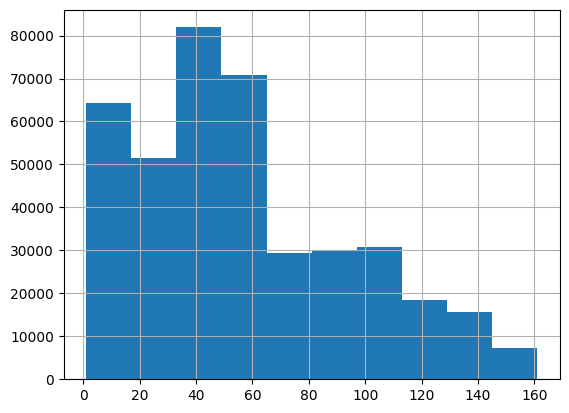

In [3]:
print(data[data["description"].map(pd.isna)].shape[0] / data.shape[0])

data["description"].map(str).map(len).hist()
plt.show()

In [4]:
data_sampled = data.sample(10000, random_state=42)
data_sampled = data_sampled[~data_sampled["description"].map(pd.isna)]
data_sampled["description"] = data_sampled["description"].map(str)
data_sampled["doc_id"] = data_sampled.groupby(by=list(data_sampled.columns)).ngroup()

In [48]:
input_texts = ["passage: " + text for text in data_sampled.description.iloc[:5].tolist()]

In [56]:
["passage: " + text for text in data_sampled.description.iloc[:5].tolist()]

['passage: #fashion #мода #красота #стиль #образ #модныйлук',
 'passage: #уходзакожей #уходзасобой #бьютирутина #бьюти #ноготочки #маникюр #прическа #укладка #уход #бьютирутина',
 'passage: #красивыедевушки #танец #грудь #boobs',
 'passage: #мульт , #мультики , #мультик , #мультфильм , #мультфильмы , #симпсоны , #грифины , #трикота , #дисней',
 'passage: #лайфхаки , #эксперименты , #roblox , #игрушки , #diy , #танцы']

In [49]:
def e5_embedding(texts: List[str], model, tokenizer) -> List[List[float]]:
    """Each input text should start with "query: " or "passage: ", even for non-English texts."""
    def _average_pool(last_hidden_states: Tensor,
                     attention_mask: Tensor) -> Tensor:
        last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
        return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]
    
    # Tokenize the input texts
    batch_dict = tokenizer(input_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')
    
    outputs = model(**{k: v.to(model.device) for k, v in batch_dict.items()})
    embeddings = _average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
    
    # normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)

    return embeddings.detach().cpu().tolist()


tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-base')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-base')

embs = e5_embedding(input_texts, model, tokenizer)

In [55]:
embs

[0.0005932620260864496,
 0.0061401017010211945,
 -0.04057364910840988,
 0.03363795205950737,
 0.004419023636728525,
 -0.023500092327594757,
 -0.037011101841926575,
 -0.01236569881439209,
 0.015871718525886536,
 0.01723613403737545,
 -0.027970625087618828,
 -0.013470172882080078,
 0.13180610537528992,
 -0.010503680445253849,
 -0.04432331770658493,
 -0.04193810001015663,
 0.017414763569831848,
 -0.014385435730218887,
 0.028439564630389214,
 0.018115820363163948,
 0.03113260492682457,
 -0.0498412624001503,
 0.054766807705163956,
 -0.016740707680583,
 0.022214921191334724,
 -0.0047955322079360485,
 0.019955182448029518,
 0.04506935551762581,
 -0.012276452034711838,
 0.04442616179585457,
 0.03763503208756447,
 -0.031417254358530045,
 0.024951055645942688,
 0.04119636118412018,
 0.053868554532527924,
 0.03264463320374489,
 -0.039798345416784286,
 -0.027151571586728096,
 0.00964465644210577,
 0.015265039168298244,
 0.010414528660476208,
 0.020950790494680405,
 -0.00047464307863265276,
 -0.025

In [44]:
def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]


# Each input text should start with "query: " or "passage: ", even for non-English texts.
# For tasks other than retrieval, you can simply use the "query: " prefix.
input_texts = ["passage: " + text for text in data_sampled.description.iloc[:5].tolist()]
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-base')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-base')

# Tokenize the input texts
batch_dict = tokenizer(input_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')

outputs = model(**batch_dict)
embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

# normalize embeddings
norm_embeddings = F.normalize(embeddings, p=2, dim=1)

In [45]:
norm_embeddings[0].detach().numpy()

array([ 1.55028151e-02,  2.93747596e-02, -1.83117427e-02,  2.02155299e-02,
        1.16954884e-02, -2.00737342e-02, -2.68259309e-02, -2.75195129e-02,
        3.66922021e-02,  2.16559395e-02, -4.37794812e-02, -3.16461250e-02,
        1.27639741e-01,  1.39001179e-02, -2.76332907e-02, -4.08349074e-02,
        9.02391970e-03, -1.06812799e-02,  3.57117392e-02,  8.99734534e-03,
        6.11675112e-03, -1.52547676e-02,  4.56094295e-02, -6.54353388e-03,
        1.78340171e-02,  4.93339589e-03,  2.98380982e-02,  4.39201221e-02,
       -1.53017826e-02,  2.05854867e-02,  4.57306542e-02, -2.55820919e-02,
        1.34168183e-02,  2.30371151e-02,  2.63831560e-02,  4.39835787e-02,
       -6.13496592e-03, -4.10200395e-02,  6.73692580e-03,  3.16642001e-02,
       -6.84213312e-03,  4.42629419e-02,  2.23064376e-03, -1.63944922e-02,
        3.48055027e-02, -3.72357108e-02,  3.65104228e-02,  4.43761498e-02,
       -2.54429560e-02, -1.82655342e-02, -9.77335311e-03,  1.87491961e-02,
        2.55425274e-02,  

In [47]:
t1

array([ 1.55028356e-02,  2.93747522e-02, -1.83117595e-02,  2.02155150e-02,
        1.16954912e-02, -2.00737230e-02, -2.68259216e-02, -2.75195185e-02,
        3.66922058e-02,  2.16559451e-02, -4.37794626e-02, -3.16461511e-02,
        1.27639771e-01,  1.39001207e-02, -2.76333094e-02, -4.08348925e-02,
        9.02388897e-03, -1.06812995e-02,  3.57117578e-02,  8.99730064e-03,
        6.11675112e-03, -1.52547183e-02,  4.56094295e-02, -6.54361257e-03,
        1.78340133e-02,  4.93338145e-03,  2.98381336e-02,  4.39200737e-02,
       -1.53018404e-02,  2.05854606e-02,  4.57306542e-02, -2.55820919e-02,
        1.34168547e-02,  2.30371859e-02,  2.63831727e-02,  4.39836048e-02,
       -6.13495847e-03, -4.10199948e-02,  6.73693419e-03,  3.16641815e-02,
       -6.84214709e-03,  4.42629382e-02,  2.23064772e-03, -1.63945276e-02,
        3.48054990e-02, -3.72356921e-02,  3.65104042e-02,  4.43761535e-02,
       -2.54429728e-02, -1.82655361e-02, -9.77333728e-03,  1.87492147e-02,
        2.55425535e-02,  

In [46]:
embedder = SentenceTransformer(f'intfloat/multilingual-e5-base').to(device)

def e5_embed(query: str, model):
    embeddings = model.encode(sentences=[query], convert_to_tensor=False, normalize_embeddings=True)
    return  embeddings[0]

t1 = e5_embed(input_texts[0], embedder)

/home/ilnaz/miniconda3/envs/hackaton_msk/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [92]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence").to(device)

def embed_bert_cls(text: Tuple[str, List[str]], model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.pooler_output.cpu().numpy()
    return embeddings if isinstance(text, list) else list(embeddings[0])

In [168]:
# tokenizer.tokenize("Обзор Наушники Anker SOUNDCORE Note i")
# print(embed_bert_cls(['привет мир', 'путешествия'], model, tokenizer).shape)

In [169]:
# data_sampled["embedding"] = data_sampled["description"].map(lambda x: embed_bert_cls(text=x, model=model, tokenizer=tokenizer))
data_sampled["embedding"] = data_sampled["description"].map(lambda x: e5_embed(x, model=embedder))

In [170]:
data_sampled.sample(10)

,link,description,doc_id,embedding
388340,https://cdn-st.rutubelist.ru/media/65/df/62ebc...,#аниме #анимеэдит #anime #артаниме #анимемемы ...,3390,"[0.008385945, 0.0026607562, -0.045216233, 0.04..."
275418,https://cdn-st.rutubelist.ru/media/3a/1b/eff6e...,@shakira ❤️ до сих пор люблю и восхищаюсь ей б...,1920,"[-0.007624531, 0.044974864, -0.007109467, 0.05..."
369219,https://cdn-st.rutubelist.ru/media/27/73/9e215...,#мнение #ИринаХакамада #reel,1311,"[0.016481426, 0.03884183, -0.0056492393, 0.011..."
283955,https://cdn-st.rutubelist.ru/media/f0/43/f9259...,#авто#vehicle#асмр#bentley,8077,"[0.011070593, 0.0127111515, 0.0015930191, 0.05..."
228938,https://cdn-st.rutubelist.ru/media/10/94/babbb...,"#егэ2023 , #огэ2023 , #наука , #егэ , #огэ , #...",540,"[-0.0075030383, 0.045570135, -0.007533962, 0.0..."
145336,https://cdn-st.rutubelist.ru/media/1c/ba/85a43...,#мульт #мультик #мультики #мультфильм #мультфи...,961,"[-0.025676649, -0.020119779, -0.033129305, 0.0..."
334480,https://cdn-st.rutubelist.ru/media/ee/79/16bac...,ТОП-5 ЛУЧШИХ АНИМЕ В ЖАНРА ИСЕКАЙ Ч-3#топ5 #то...,8002,"[-0.010728716, 0.02290772, -0.04282777, 0.0373..."
90553,https://cdn-st.rutubelist.ru/media/5d/10/3ef77...,#красивыедевушки #cutegirls #sexygirls #грудь ...,3079,"[0.022103464, 0.01435982, -0.025164416, 0.0136..."
75311,https://cdn-st.rutubelist.ru/media/e0/23/9f7a1...,#forkids #детскийконтент #длядетей #комедия,7497,"[0.0039113266, 0.03791594, -0.035455633, 0.042..."
83458,https://cdn-st.rutubelist.ru/media/ef/e2/a6198...,Игра один на один против игрока 2 метра!#спорт...,8058,"[0.0017260301, 0.032932285, -0.03133757, 0.004..."


In [182]:
class QDocument:
    def __init__(self, 
                 collection_name: str,
                 url: str = "localhost", 
                 port: int = 6333,):
        self.client = QdrantClient(url=url, port=port)
        self.collection_name = collection_name

    def get_collection_info(self):
        response = self.client.get_collection(collection_name=self.collection_name)
        return response
    
    def create_collection(self, emb_dim: int = 100):
        self.client.create_collection(
            collection_name=self.collection_name,
            vectors_config=VectorParams(size=emb_dim, distance=Distance.COSINE, on_disk=False),
            timeout=1000,
        )
    
    def delete_collection(self):
        self.client.delete_collection(collection_name=self.collection_name)
    
    def add_documents(self, doc_ids: List[int], embeddings: List[List[float]], metadata: List[dict]):
        self.client.upsert(
            collection_name=self.collection_name,
            points=models.Batch(
                ids=doc_ids,
                payloads=metadata,
                vectors=embeddings,
            ),
        
        )
        
    def retrieve_documents(self, doc_ids: List[int]) -> dict:
        response = self.client.retrieve(
            collection_name=self.collection_name,
            ids=doc_ids,
            with_payload=True,
            with_vectors=True,
        )
        return response
    
    def count_documents(self) -> dict:
        response = self.client.count(
            collection_name=self.collection_name,
            exact=True,
        )
        return response
    
    def search(self, embedding: List[float]) -> dict:
        response = self.client.search(
            collection_name=self.collection_name,
            search_params=models.SearchParams(hnsw_ef=128, exact=False),
            query_vector=embedding,
            query_filter=None, 
            limit=24,
            with_vectors=False,
            with_payload=True,
#             score_threshold=100,  # [0;1] cos
        )
        return response

In [183]:
vdb = QDocument(collection_name="test")

vdb.delete_collection()
vdb.create_collection(emb_dim=768)

In [184]:
embeddings = data_sampled["embedding"].values.tolist()
metadata = [{"description": description} for description in data_sampled["description"].values.tolist()]
doc_ids = data_sampled["doc_id"].values.tolist()

In [185]:
%%time

step = 1000
for t in range(0, len(doc_ids), step):
    vdb.add_documents(doc_ids=doc_ids[t:step + t], 
                             embeddings=embeddings[t:step + t], 
                             metadata=metadata[t:step + t])

CPU times: user 919 ms, sys: 50.6 ms, total: 970 ms
Wall time: 2.09 s


In [220]:
query_embedding = e5_embed("dick", model=embedder)

In [221]:
vdb.search(embedding=query_embedding)

[ScoredPoint(id=179, version=4, score=0.8270242, payload={'description': 'Chicago'}, vector=None, shard_key=None),
 ScoredPoint(id=3343, version=4, score=0.8219623, payload={'description': 'комплект'}, vector=None, shard_key=None),
 ScoredPoint(id=5827, version=4, score=0.82001346, payload={'description': '#shorts'}, vector=None, shard_key=None),
 ScoredPoint(id=3689, version=3, score=0.8198068, payload={'description': '🔥'}, vector=None, shard_key=None),
 ScoredPoint(id=2618, version=7, score=0.8198068, payload={'description': '🔥'}, vector=None, shard_key=None),
 ScoredPoint(id=2597, version=7, score=0.8185453, payload={'description': '#красивыедевушки #бикини #грудь'}, vector=None, shard_key=None),
 ScoredPoint(id=3351, version=6, score=0.8184392, payload={'description': '#дельфин'}, vector=None, shard_key=None),
 ScoredPoint(id=6456, version=3, score=0.81627846, payload={'description': '#asmr #keyboard #typing #thock'}, vector=None, shard_key=None),
 ScoredPoint(id=8439, version=5, s

In [177]:
vdb.count_documents()

CountResult(count=8629)